In [2]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_ind, f_oneway, f
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Your registered API key is: 756f3a5e976b7a7f3a7f3bb1bc19e1e4 Documentation is available on the St. Louis Fed web services website.

In [48]:
# Replace with your actual FRED API key
api_key = '756f3a5e976b7a7f3a7f3bb1bc19e1e4'
fred = Fred(api_key=api_key)

WORKFLOW:


In [49]:
# List of FRED series IDs for key factors
#key factors: home prices, inflation, unemployment rate, interest rates, economic activity, population
series_ids = {
    'S&P Case-Schiller Home Price Index': 'CSUSHPINSA', #home prices
    'Consumer Price Index for All Urban Consumers: All Items': 'CPIAUCSL', #inflation
    '10-Year Breakeven Inflation Rate':'T10YIE', #inflation
    'Unemployment Rate': 'UNRATE', #unemployment rate
    '30-Year Fixed Rate Mortgage Average in the United States': 'MORTGAGE30US', #interest rates
    'Federal Funds Rate': 'FEDFUNDS', #interest rates
    'Personal Consumption Expenditures': 'PCE', #economic activity
    'Real Gross Domestic Product': 'GDP', #economic activity
    'Median Household Income in the United States':'MEHOINUSA646N', #economic activity
    'Population Level':'CNP16OV' #population
}

# Fetch data and store in a dictionary
data = {}
for description, series_id in series_ids.items():
    data[description] = fred.get_series(series_id)

# Convert dictionary to a DataFrame
df = pd.DataFrame(data)

# Restrict data to the last 20 years
df = df[df.index >= '2004-01-01']

# Save the DataFrame to a CSV file
df.to_csv('merged_housing_data.csv', index_label='date')

print("Data downloaded and saved as 'merged_housing_data.csv'.")


Data downloaded and saved as 'merged_housing_data.csv'.


In [50]:
# Load the data
df = pd.read_csv('merged_housing_data.csv')

# Inspect the data to find the correct date column name
#print(df.head())
#print(df.columns)
correct_date_column_name = 'date'
df = pd.read_csv('merged_housing_data.csv', parse_dates=[correct_date_column_name], index_col=correct_date_column_name)

# Handle missing values by forward-filling
df.fillna(method='ffill', inplace=True)

# Normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

print("Data preprocessed.")


Data preprocessed.


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the target variable (S&P Case-Schiller Home Price Index)
y = df_scaled['S&P Case-Schiller Home Price Index']
X = df_scaled.drop(columns=['S&P Case-Schiller Home Price Index'])

# Check for NaN or infinite values
print("Checking for NaN or infinite values in the dataset...")
print("NaNs in features:", np.any(np.isnan(X)))
print("NaNs in target:", np.any(np.isnan(y)))
print("Infinities in features:", np.any(np.isinf(X)))
print("Infinities in target:", np.any(np.isinf(y)))

# Handle missing values by removing rows with NaNs or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]  # Ensure the target variable y aligns with the filtered X




Checking for NaN or infinite values in the dataset...
NaNs in features: True
NaNs in target: False
Infinities in features: False
Infinities in target: False


Correlation between home prices and other features:
Consumer Price Index for All Urban Consumers: All Items     0.873784
10-Year Breakeven Inflation Rate                            0.164451
Unemployment Rate                                          -0.566603
30-Year Fixed Rate Mortgage Average in the United States    0.202220
Federal Funds Rate                                          0.442351
Personal Consumption Expenditures                           0.905027
Real Gross Domestic Product                                 0.906232
Median Household Income in the United States                0.895678
Population Level                                            0.753871
Name: S&P Case-Schiller Home Price Index, dtype: float64


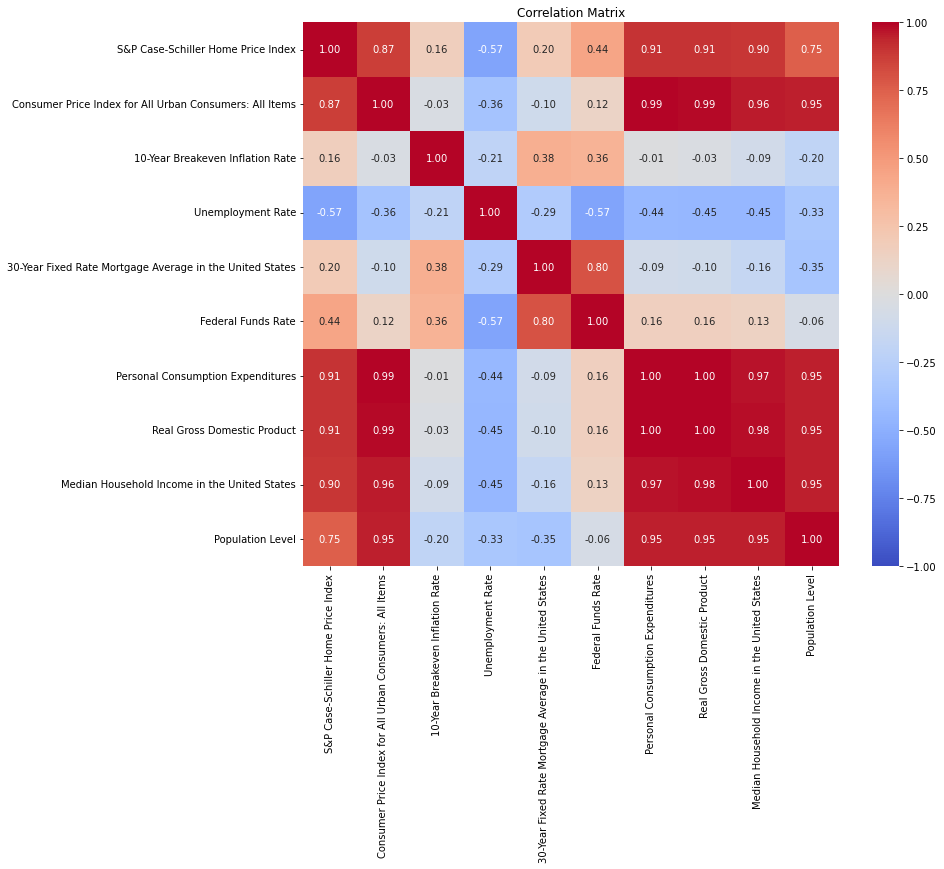

In [54]:
# Calculate correlation matrix
correlation_matrix = df_scaled.corr()

# Extract correlations between home price index and other features
home_price_correlations = correlation_matrix['S&P Case-Schiller Home Price Index'].drop('S&P Case-Schiller Home Price Index')

# Display the correlations
print("Correlation between home prices and other features:")
print(home_price_correlations)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


LINEAR REGRESSION:

In [9]:
#linear regression
# After handling NaNs, split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation:\nMSE: {mse}\nR^2: {r2}")

Model Evaluation:
MSE: 0.0265116010165944
R^2: 0.9730644013508861


In [15]:
# Getting the coefficients (impact) of each feature
coefficients = model.coef_

print("Coefficients (Impact of Features):")
for feature, coefficient in zip(X.columns, coefficients):
    print(f"{feature}: {coefficient}")


Coefficients (Impact of Features):
Consumer Price Index for All Urban Consumers: All Items: -0.48206162914736334
10-Year Breakeven Inflation Rate: 0.020584344196205452
Unemployment Rate: 0.028914768798331943
30-Year Fixed Rate Mortgage Average in the United States: 0.032234071028815724
Federal Funds Rate: 0.05584381490719094
Personal Consumption Expenditures: 0.10500188610760158
Real Gross Domestic Product: 1.6367668696244524
Median Household Income in the United States: 0.6273773852095453
Population Level: -1.0125960763392048


In [23]:
from scipy.stats import f_oneway

# Perform one-way ANOVA on home prices across different economic indicators
# Assuming you want to compare home prices based on different economic indicators as groups
f_statistic, p_value = f_oneway(df_scaled['S&P Case-Schiller Home Price Index'], df_scaled['Consumer Price Index for All Urban Consumers: All Items'], df_scaled['Unemployment Rate'])

print(f"One-Way ANOVA results:\nF-statistic: {f_statistic}, p-value: {p_value}")


One-Way ANOVA results:
F-statistic: 9.353659630453865e-29, p-value: 1.0


In [56]:
for feature in features:
    # Group the data by the feature
    groups = df.groupby(feature)

    # Extract the housing price data for each group
    data = [group[1]['S&P Case-Schiller Home Price Index'] for group in groups]

    # Perform one-way ANOVA
    f_statistic, p_value = f_oneway(*data)

    # Display the feature name and its ANOVA p-value
    print(f"Feature: {feature}")
    print("ANOVA f-statistic:", f_statistic)
    print("ANOVA p-value:", p_value)
    print('')



Feature: Consumer Price Index for All Urban Consumers: All Items
ANOVA f-statistic: 311838.03286784125
ANOVA p-value: 0.0

Feature: 10-Year Breakeven Inflation Rate
ANOVA f-statistic: 2.966497011334756
ANOVA p-value: 3.257183637489848e-46

Feature: Unemployment Rate
ANOVA f-statistic: 190.301647416173
ANOVA p-value: 0.0

Feature: 30-Year Fixed Rate Mortgage Average in the United States
ANOVA f-statistic: 32.4035080475173
ANOVA p-value: 0.0

Feature: Federal Funds Rate
ANOVA f-statistic: 169.44934969100066
ANOVA p-value: 0.0

Feature: Personal Consumption Expenditures
ANOVA f-statistic: inf
ANOVA p-value: 0.0

Feature: Real Gross Domestic Product
ANOVA f-statistic: 75391.91829904918
ANOVA p-value: 0.0

Feature: Median Household Income in the United States
ANOVA f-statistic: 22097.561602910468
ANOVA p-value: 0.0

Feature: Population Level
ANOVA f-statistic: inf
ANOVA p-value: 0.0



C:\Users\Acer\anaconda3\lib\site-packages\scipy\stats\stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


In [57]:
# Split data into two periods (e.g., before and after 2010)
pre_2020 = df_scaled[df_scaled.index < '2020-01-01']
post_2020 = df_scaled[df_scaled.index >= '2020-01-01']


In [58]:
# List of features to compare with home prices
features = ['Consumer Price Index for All Urban Consumers: All Items', 
            '10-Year Breakeven Inflation Rate', 'Unemployment Rate', 
            '30-Year Fixed Rate Mortgage Average in the United States', 
            'Federal Funds Rate', 'Personal Consumption Expenditures', 
            'Real Gross Domestic Product', 'Median Household Income in the United States', 
            'Population Level']

# Function to bin continuous features
def bin_continuous_feature(series, bins=5):
    return pd.cut(series, bins=bins, labels=False)

# Perform one-way ANOVA for each feature
for feature in features:
    # Bin the feature if it's continuous
    if df_scaled[feature].dtype in [np.float64, np.int64]:
        df_scaled[feature] = bin_continuous_feature(df_scaled[feature])
    
    # Group the data by the feature
    groups = df_scaled.groupby(df_scaled[feature])

    # Extract the housing price data for each group
    data = [group[1]['S&P Case-Schiller Home Price Index'] for group in groups]

    # Perform one-way ANOVA
    f_statistic, p_value = f_oneway(*data)

    # Display the feature name and its ANOVA p-value
    print(f"Feature: {feature}")
    print("ANOVA f_statistic:", f_statistic)
    print("ANOVA p-value:", p_value)


Feature: Consumer Price Index for All Urban Consumers: All Items
ANOVA f_statistic: 17582.473517130307
ANOVA p-value: 0.0
Feature: 10-Year Breakeven Inflation Rate
ANOVA f_statistic: 15.120306136978488
ANOVA p-value: 2.6874991068013366e-12
Feature: Unemployment Rate
ANOVA f_statistic: 460.95628559285177
ANOVA p-value: 0.0
Feature: 30-Year Fixed Rate Mortgage Average in the United States
ANOVA f_statistic: 653.5329455680148
ANOVA p-value: 0.0
Feature: Federal Funds Rate
ANOVA f_statistic: 349.25213034855386
ANOVA p-value: 6.185841549085207e-268
Feature: Personal Consumption Expenditures
ANOVA f_statistic: 14947.665899057609
ANOVA p-value: 0.0
Feature: Real Gross Domestic Product
ANOVA f_statistic: 17262.56365510183
ANOVA p-value: 0.0
Feature: Median Household Income in the United States
ANOVA f_statistic: 5907.54004060624
ANOVA p-value: 0.0
Feature: Population Level
ANOVA f_statistic: 5786.86866841768
ANOVA p-value: 0.0


Interpretation
Consumer Price Index for All Urban Consumers: All Items: High F-statistic and p-value of 0.0 indicate a strong relationship.
10-Year Breakeven Inflation Rate: Significant relationship with a very low p-value.
Unemployment Rate: Strongly significant relationship.
30-Year Fixed Rate Mortgage Average in the United States: Highly significant.
Federal Funds Rate: Very strong relationship.
Personal Consumption Expenditures: Highly significant.
Real Gross Domestic Product: Extremely significant relationship.
Median Household Income in the United States: Very strong relationship.
Population Level: Highly significant.

In [37]:
#t tests

# Perform t-test for each feature
for feature in features:
    t_statistic, p_value = ttest_ind(pre_2020[feature], post_2020[feature])
    print(f"T-Test results for {feature}:\nT-statistic: {t_statistic}, p-value: {p_value}\n")


T-Test results for Consumer Price Index for All Urban Consumers: All Items:
T-statistic: -95.8965444063375, p-value: 0.0

T-Test results for 10-Year Breakeven Inflation Rate:
T-statistic: -8.350038604072054, p-value: 8.573105335851229e-17

T-Test results for Unemployment Rate:
T-statistic: 15.768857960548207, p-value: 8.247801294112381e-55

T-Test results for 30-Year Fixed Rate Mortgage Average in the United States:
T-statistic: -1.2581018481337616, p-value: 0.20840900096140832

T-Test results for Federal Funds Rate:
T-statistic: -13.529217053667557, p-value: 4.829729280717909e-41

T-Test results for Personal Consumption Expenditures:
T-statistic: -98.62431645591175, p-value: 0.0

T-Test results for Real Gross Domestic Product:
T-statistic: -98.72582853293007, p-value: 0.0

T-Test results for Median Household Income in the United States:
T-statistic: -99.50909946858155, p-value: 0.0

T-Test results for Population Level:
T-statistic: -67.37710063770581, p-value: 0.0



In [38]:
# Perform F-test for each feature
for feature in features:
    # Calculate variances
    var_pre_2020 = np.var(pre_2020[feature], ddof=1)
    var_post_2020 = np.var(post_2020[feature], ddof=1)
    
    # Perform F-test
    f_statistic = var_pre_2020 / var_post_2020
    dof_pre = len(pre_2020) - 1
    dof_post = len(post_2020) - 1
    p_value = 1 - f.cdf(f_statistic, dof_pre, dof_post)
    
    print(f"F-Test results for {feature}:\nF-statistic: {f_statistic}, p-value: {p_value}\n")


F-Test results for Consumer Price Index for All Urban Consumers: All Items:
F-statistic: 0.9356046567340124, p-value: 0.9275944187510584

F-Test results for 10-Year Breakeven Inflation Rate:
F-statistic: 0.9280193641044623, p-value: 0.9491419974786544

F-Test results for Unemployment Rate:
F-statistic: 0.6326744710995007, p-value: 1.0

F-Test results for 30-Year Fixed Rate Mortgage Average in the United States:
F-statistic: 0.31586953958110586, p-value: 1.0

F-Test results for Federal Funds Rate:
F-statistic: 0.5307141687686442, p-value: 1.0

F-Test results for Personal Consumption Expenditures:
F-statistic: 0.950759881521037, p-value: 0.8657587506521232

F-Test results for Real Gross Domestic Product:
F-statistic: 1.1118004918120443, p-value: 0.011830651660905467

F-Test results for Median Household Income in the United States:
F-statistic: 5.482676387390972, p-value: 1.1102230246251565e-16

F-Test results for Population Level:
F-statistic: 14.591819691939918, p-value: 1.1102230246251

In [43]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Model Evaluation:\nMSE: {mse_rf}\nR^2: {r2_rf}")

Random Forest Model Evaluation:
MSE: 1.2598669466398501e-06
R^2: 0.9999987199841155


Feature importances from Random Forest:
Consumer Price Index for All Urban Consumers: All Items: 0.7858732026134383
Population Level: 0.09760800720794892
Real Gross Domestic Product: 0.05153415342313173
Unemployment Rate: 0.04824692335005623
Personal Consumption Expenditures: 0.010876976682385386
Federal Funds Rate: 0.0034866444086152438
Median Household Income in the United States: 0.0018549988188981226
30-Year Fixed Rate Mortgage Average in the United States: 0.0003809625227752735
10-Year Breakeven Inflation Rate: 0.0001381309727509359


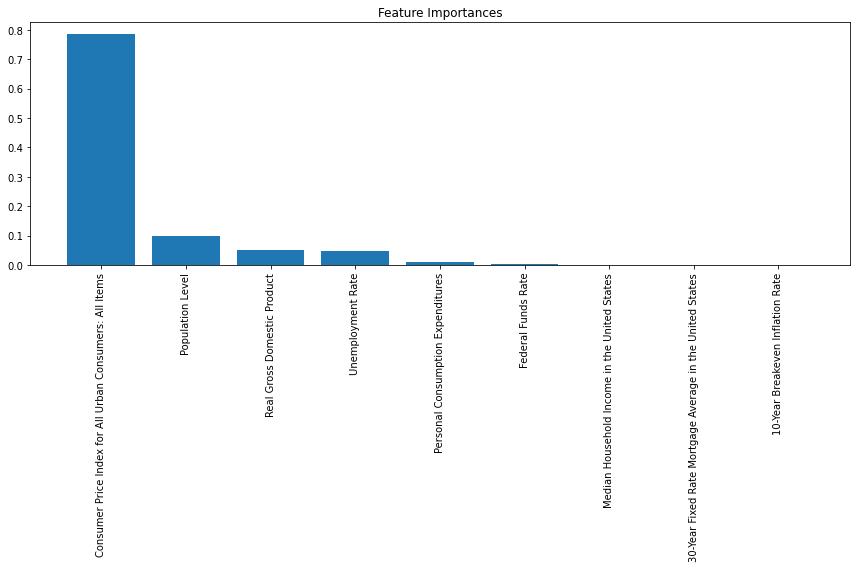

In [44]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances from Random Forest:")
for i in range(X.shape[1]):
    print(f"{X.columns[indices[i]]}: {importances[indices[i]]}")

import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()